# SPKIR CG data deep dive 1.1

In this notebook we use data stored in the kdata drive on the OOI Jupyter Hub. 
<!-- ### Ref Des: CP01CNSM-RID26-08-SPKIRB000 -->

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm

from ooi_data_explorations.common import list_methods, list_streams, get_annotations, add_annotation_qc_flags, load_kdata, get_vocabulary, update_dataset
from ooi_data_explorations.uncabled.process_spkir import spkir_datalogger

from ooinet import M2M # not sure if importing just M2M is correct/whether there is a class associated with this module

from qartod_testing.plotting import nanfill_time_gaps

In [2]:
# Set parameters for data request 
refdes = 'CP03ISSM-RID26-08-SPKIRB000'
site, node, sensor = refdes.split('-', 2)

In [3]:
# Create dict of methods and associated data streams
methods = list_methods(site, node, sensor)

streams = {}
for method in methods:
    streams[method] = list_streams(site, node, sensor, method)

streams

{'recovered_host': ['spkir_abj_dcl_instrument_recovered'],
 'telemetered': ['spkir_abj_dcl_instrument']}

In [4]:
# View deployment information
deployments = M2M.get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-SPKIRB-00270,1397,40.3619,-70.878,7.0,2014-12-14 18:53:00,2014-12-28 16:30:00,KN224,AT31
1,2,CGINS-SPKIRB-00273,1395,40.35945,-70.88528,7.0,2015-05-09 00:57:00,2015-10-21 18:50:00,AT27,AT31
2,3,CGINS-SPKIRB-00290,1332,40.36472,-70.88837,7.0,2015-10-21 17:44:00,2016-05-14 13:45:00,AT31,AR4
3,4,CGINS-SPKIRB-00301,1840,40.35945,-70.88498,7.0,2016-05-28 14:43:00,2016-10-15 12:14:00,AR4,AR8
4,5,CGINS-SPKIRB-00290,1332,40.36192,-70.87827,7.0,2016-10-11 13:39:00,2017-06-15 15:56:00,AR8,AR18
5,6,CGINS-SPKIRB-00274,1406,40.367067,-70.881617,7.0,2017-06-15 13:43:00,2017-11-01 14:17:00,AR18,AR24
6,7,CGINS-SPKIRB-00238,2413,40.358983,-70.885467,7.0,2017-11-01 12:22:00,2018-03-28 16:56:00,AR24,AR28
7,8,CGINS-SPKIRB-00269,1364,40.36718,-70.88215,7.0,2018-03-25 15:27:00,2018-10-26 19:52:00,AR28,AR31
8,9,CGINS-SPKIRB-00270,1397,40.36728,-70.88105,7.0,2018-10-29 03:43:00,2019-04-06 18:51:00,AR31,AR34
9,10,CGINS-SPKIRB-00229,2380,40.36723,-70.88147,7.0,2019-04-07 14:42:00,2019-10-01 11:58:00,AR34,AR39


In [161]:
## View annotations
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)

if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

annotations
# annotations['annotation'][5]

# Note: now I have moved the lines that add a human-readable date time up here where the annotations are displayed, however I'm not sure if the begin and endDT columns still need 
# to exist. I would like to remove them because they are just taking up space and don't add anything to the dataFrame displayed below.

,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
0,2865,CP03ISSM,RID26,08-SPKIRB000,None,None,1604172660000,1617217320000,Deploylment 12: The UV light LED module failed...,False,swhite@whoi.edu,suspect,[],2020-10-31T19:31:00,2021-03-31T19:02:00
1,1510,CP03ISSM,RID26,None,telemetered,None,1529265880000,1540583520000,Data telemetry disabled due to chronic issues ...,False,leila@marine.rutgers.edu,None,[],2018-06-17T20:04:40,2018-10-26T19:52:00
2,1889,CP03ISSM,None,None,None,None,1578441600000,1604236560000,Deployment 11: UPDATED 2020-04-27: As of 2020-...,False,cdobson@whoi.edu,not_operational,[],2020-01-08T00:00:00,2020-11-01T13:16:00
3,2946,CP03ISSM,RID26,None,None,None,1628089200000,1630411200000,Deployment 13: * UPDATED 2021-09-11: NSIF powe...,False,cdobson@whoi.edu,not_operational,[],2021-08-04T15:00:00,2021-08-31T12:00:00
4,3264,CP03ISSM,RID26,None,None,None,1633176000000,1633939200000,Deployment 13: A gap exists in the telemetered...,False,cdobson@whoi.edu,None,[],2021-10-02T12:00:00,2021-10-11T08:00:00
5,3379,CP03ISSM,RID26,08-SPKIRB000,None,None,1628089200000,1636659000000,Deployment 13: On recovery biofouling was obse...,False,cdobson@whoi.edu,None,[],2021-08-04T15:00:00,2021-11-11T19:30:00
6,1774,CP03ISSM,RID26,08-SPKIRB000,None,None,1569505800000,1668347700000,The use of UV lamps has been implemented for b...,False,swhite@whoi.edu,None,[],2019-09-26T13:50:00,2022-11-13T13:55:00


In [150]:
annotations['annotation'][5]

'Deployment 13: On recovery biofouling was observed on the optical windows. The UV-light was powered off for approximately 1 month in August when the NSIF was shut down due to low power.'

The `for` loop above that retrieves the available streams for a given method tells us that each method only has one available data stream. Next, we will download data for the method/stream pairs.

<hr>

### Recovered host data

In [169]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 11

In [170]:
# load data from the local kdata directory
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 2/2 [00:10<00:00,  5.33s/it]


In [164]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [171]:
spkir = nanfill_time_gaps(spkir)

In [172]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                     (time: 38410, station: 1)
Coordinates:
  * time                        (time) datetime64[ns] 2019-09-26T14:00:00 ......
Dimensions without coordinates: station
Data variables: (12/22)
    internal_temperature        (station, time) float32 24.0 24.0 ... 21.0 21.0
    input_voltage               (station, time) float32 8.49 8.49 ... 8.46 8.49
    deployment                  (station, time) float32 11.0 11.0 ... 11.0 11.0
    analog_rail_voltage         (station, time) float32 5.34 5.34 ... 5.34 5.34
    raw_irradiance_412          (station, time) float32 2.246e+09 ... 2.152e+09
    raw_irradiance_444          (station, time) float32 2.292e+09 ... 2.154e+09
    ...                          ...
    downwelling_irradiance_620  (station, time) float32 5.722 6.411 ... 0.2644
    downwelling_irradiance_683  (station, time) float32 1.381 1.575 ... 0.0824
    station_name                (station) <U8 'CP03ISSM'
    lat                         (station) float32 40.36
    lon                         (station) float32 -70.89
    z                           (station) float32 7.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            7.0
    geospatial_vertical_max:            7.0

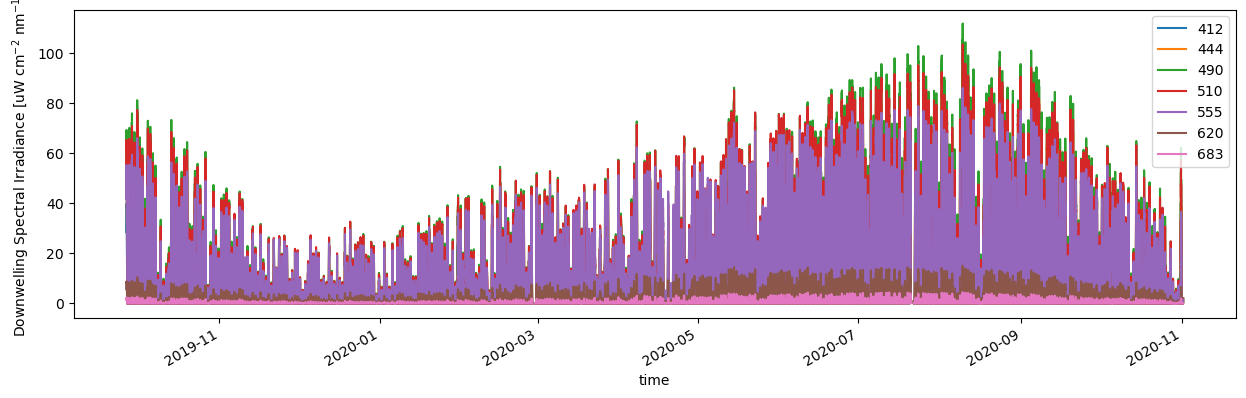

In [173]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

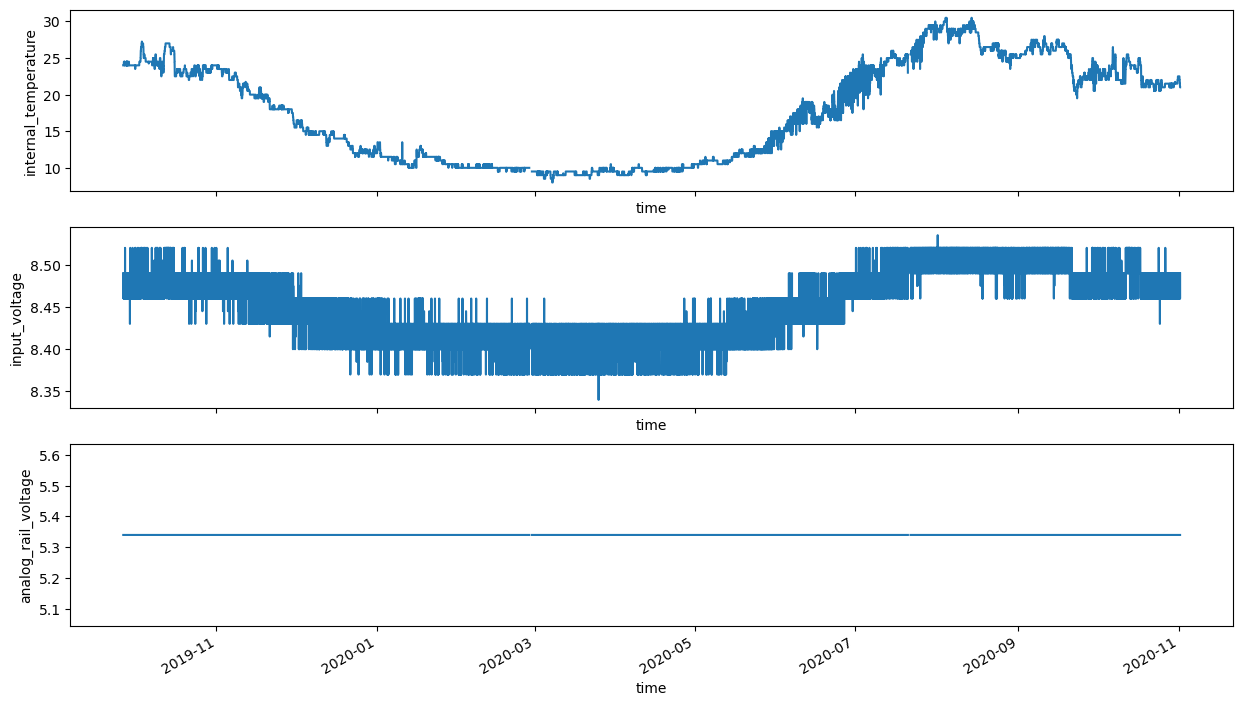

In [174]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

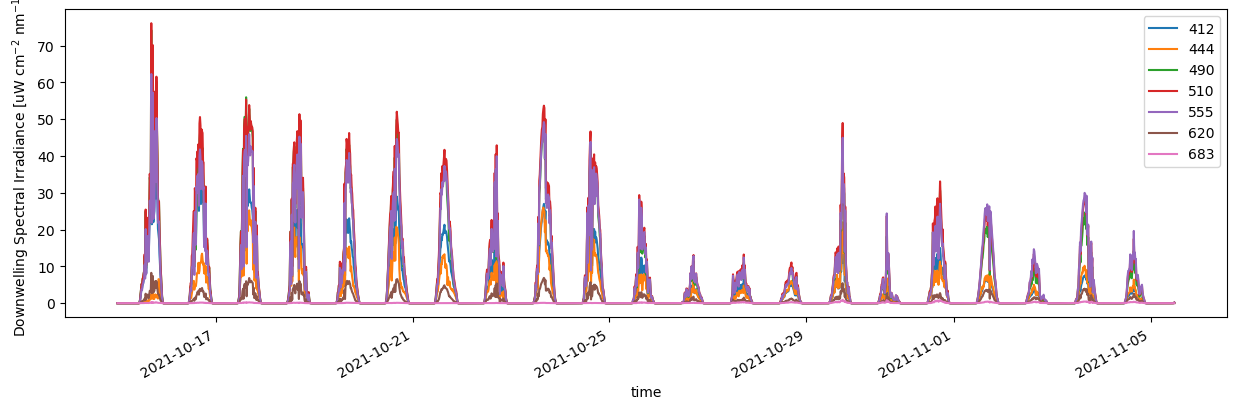

In [151]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2021-10-15','2021-11-07')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

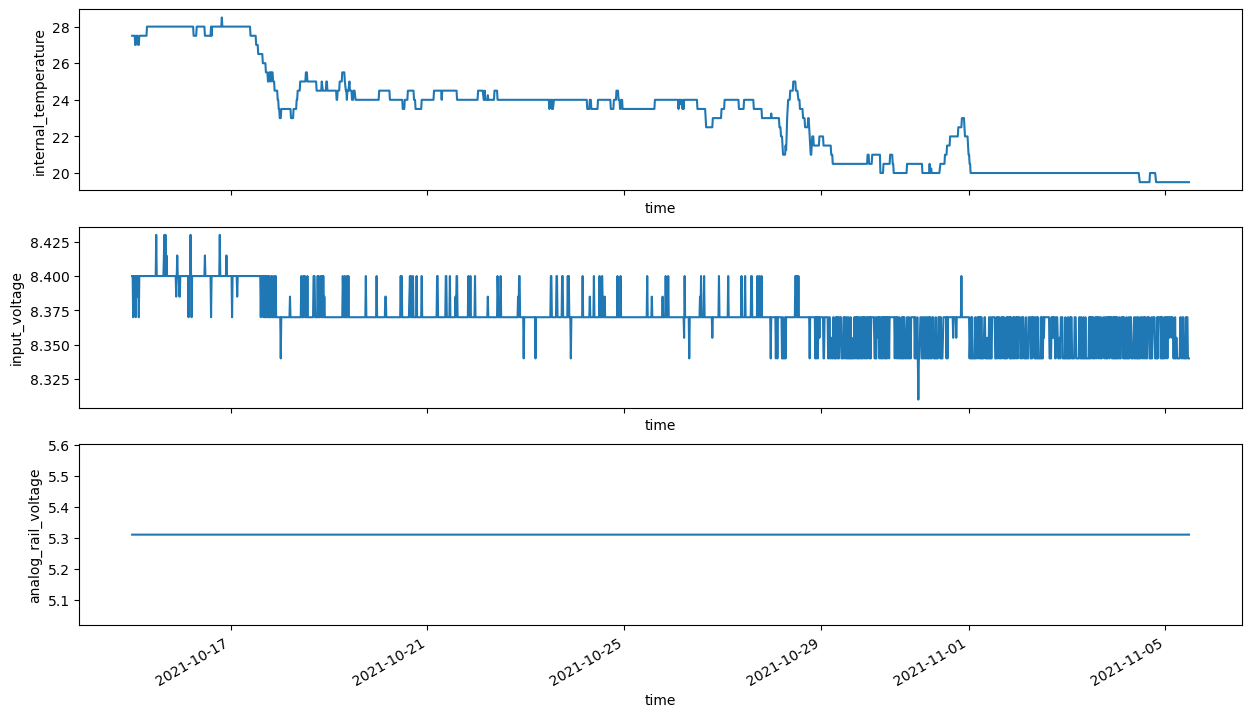

In [152]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2021-10-15','2021-11-07')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2021-10-15','2021-11-07')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2021-10-15','2021-11-07')).plot.line(ax=ax[2])

### Histograms of downwelling irradiance measurements

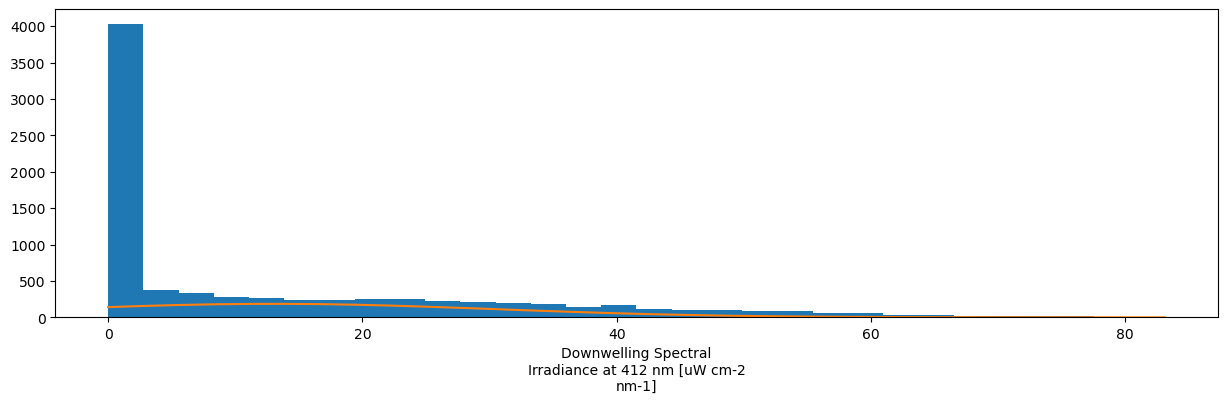

In [30]:
# histogram of downwelling irradiance @ 412 nm variable
irrad412 = spkir['downwelling_irradiance_412'][0]
# irrad412 = spkir['downwelling_irradiance_412'][0].sel(time=slice('2017-07-01'))
mu412 = irrad412.mean()
sig412 = irrad412.std()

plt.figure(figsize=(15,4))
c, x, h = irrad412.plot.hist(bins=30)
norm412 = sum(c)*norm.pdf(x, mu412, sig412)
plt.plot(x, norm412)

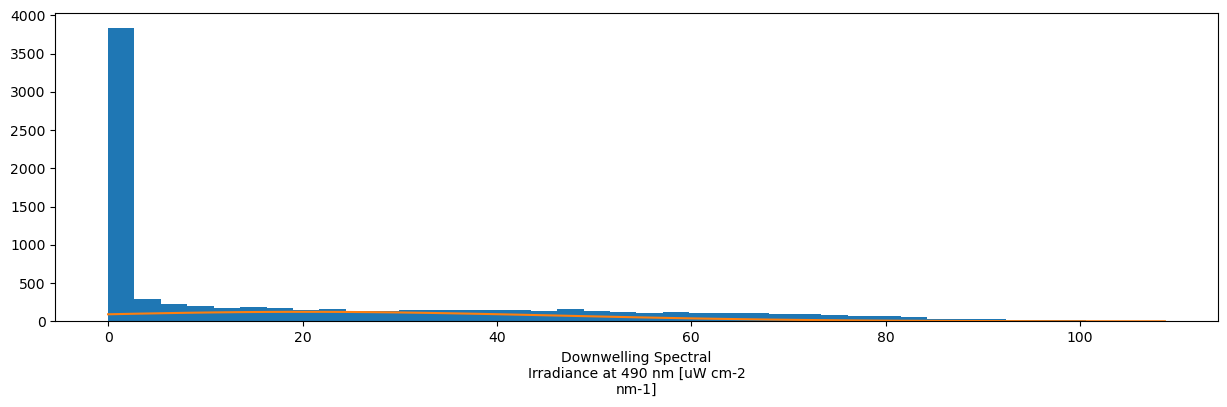

In [31]:
# histogram of downwelling irradiance @ 490 nm variable
irrad490 = spkir['downwelling_irradiance_490'][0]
# irrad490 = spkir['downwelling_irradiance_490'][0].sel(time=slice('2017-07-01'))
mu490 = irrad490.mean()
sig490 = irrad490.std()

plt.figure(figsize=(15,4))
c, x, h = irrad490.plot.hist(bins=40)
norm490 = sum(c)*norm.pdf(x, mu490, sig490)
plt.plot(x, norm490)

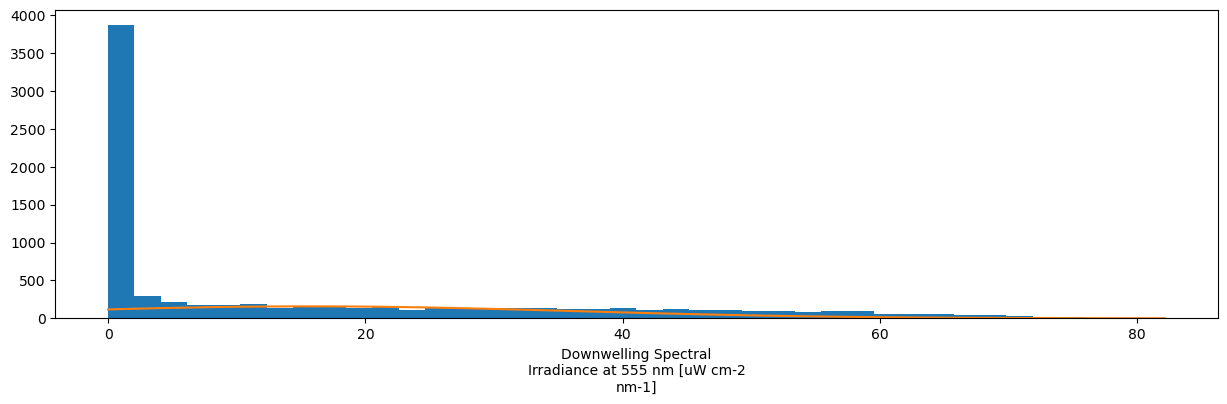

In [32]:
# histogram of downwelling irradiance @ 555 nm variable
irrad555 = spkir['downwelling_irradiance_555'][0]
# irrad555 = spkir['downwelling_irradiance_555'][0].sel(time=slice('2015-06-01'))
mu555 = irrad555.mean()
sig555 = irrad555.std()

plt.figure(figsize=(15,4))
c, x, h = irrad555.plot.hist(bins=40)
norm555 = sum(c)*norm.pdf(x, mu555, sig555)
plt.plot(x, norm555)

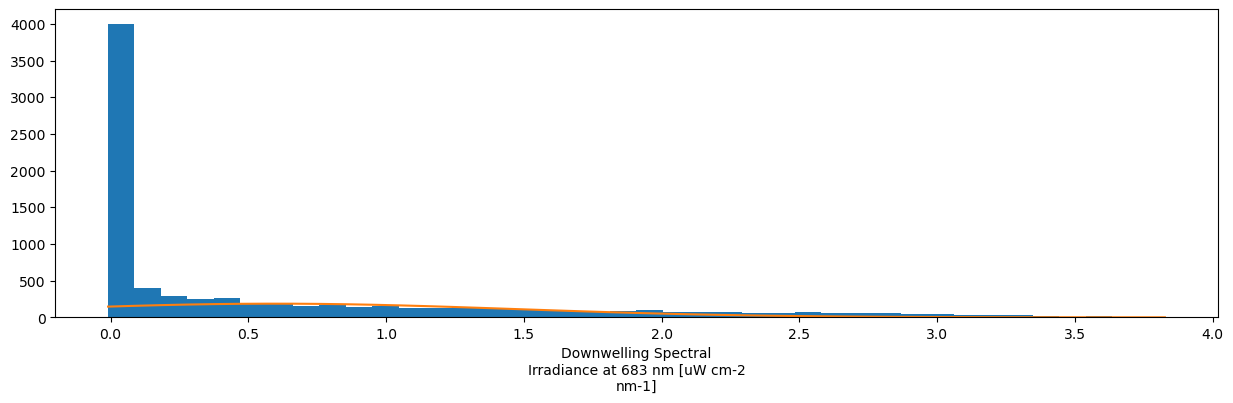

In [33]:
# histogram of downwelling irradiance @ 683 nm variable
irrad683 = spkir['downwelling_irradiance_683'][0]
# irrad683 = spkir['downwelling_irradiance_683'][0].sel(time=slice('2017-07-01'))
mu683 = irrad683.mean()
sig683 = irrad683.std()

plt.figure(figsize=(15,4))
c, x, h = irrad683.plot.hist(bins=40)
norm683 = 0.05*sum(c)*norm.pdf(x, mu683, sig683)
plt.plot(x, norm683)

In [34]:
# concat the different irradiance variables for histogram of all irradiance values
irradAll = xr.DataArray()
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        irradAll = xr.concat([irradAll, spkir[var][0]], dim='channel')
irradAll

<xarray.DataArray (channel: 8, time: 8581)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-1.24489265e-02, -1.22679379e-02, -1.27385072e-02, ...,
         3.33838081e+01,  2.91790657e+01,  2.71376114e+01],
       [-2.28602290e-02, -2.30053701e-02, -2.28148736e-02, ...,
         4.15520287e+01,  3.64205742e+01,  3.37744560e+01],
       ...,
       [-8.62311665e-03, -7.81955104e-03, -8.97590257e-03, ...,
         3.88252945e+01,  3.34404564e+01,  3.07892475e+01],
       [ 1.19705470e-02,  1.19244633e-02,  1.15373600e-02, ...,
         4.89614058e+00,  4.12962008e+00,  3.72692156e+00],
       [-4.96644620e-03, -5.32475766e-03, -4.51855734e-03, ...,
         1.25258076e+00,  1.05488253e+00,  9.43447709e-01]])
Coordinates:
  * time     (time) datetime64[ns] 2015-05-09T01:00:00 ... 2015-09-28T19:45:00
Dimensions without coordinates: channel

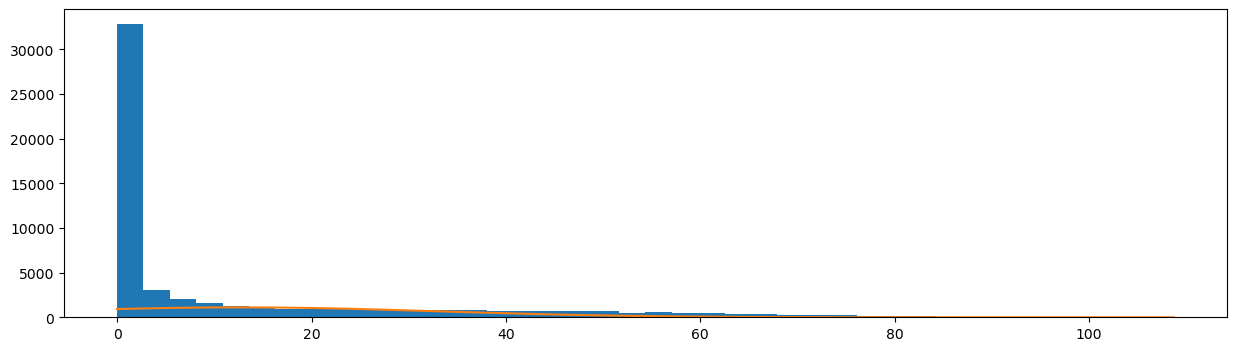

In [35]:
# histogram using all irradiance values
radAll= irradAll
muAll = radAll.mean()
sigAll = radAll.std()

plt.figure(figsize=(15,4))
c, x, h = radAll.plot.hist(bins=40)
normAll = sum(c)*norm.pdf(x, muAll, sigAll)
plt.plot(x, normAll)

### Histograms after monthly mean filter

### Spectrograms of downwelling irradiance (not burst averaged)

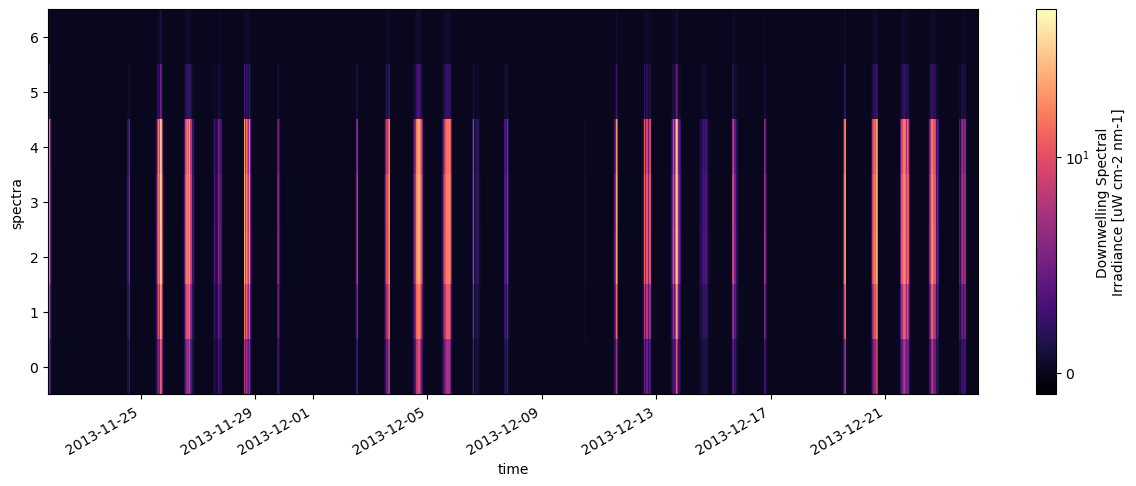

In [20]:
# Trying same plot with full resolution data with log-scale colormap (linear between -1,10)
xr.plot.pcolormesh(spkir_full_time.spkir_abj_cspp_downwelling_vector, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [28]:
# That was a bad idea so let's resample to daily
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="1D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 174, spectra: 7)>
array([[ 9.71255556e+00,  1.33028855e+01,  1.93817753e+01, ...,
         2.23164523e+01,  3.62021577e+00,  7.82912088e-01],
       [ 6.20054185e-01,  9.06080839e-01,  1.34600973e+00, ...,
         1.25914219e+00,  1.82409459e-01,  5.95385999e-02],
       [ 1.73746901e-01,  2.63608506e-01,  3.78101900e-01, ...,
         4.27118953e-01,  6.74665225e-02,  3.25888514e-02],
       ...,
       [ 7.39844170e-02,  7.86333704e-02,  8.35438973e-02, ...,
         5.61443408e-02,  8.31668786e-03,  4.77597635e-03],
       [ 2.28589437e-01,  2.76852485e-01,  3.28657073e-01, ...,
         2.09412793e-01,  2.62619446e-02,  1.17360818e-02],
       [ 2.29803754e-03,  3.92295552e-04, -2.80754229e-04, ...,
        -6.79578805e-04,  1.25565920e-03,  3.28846042e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-07 ... 2019-09-26
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

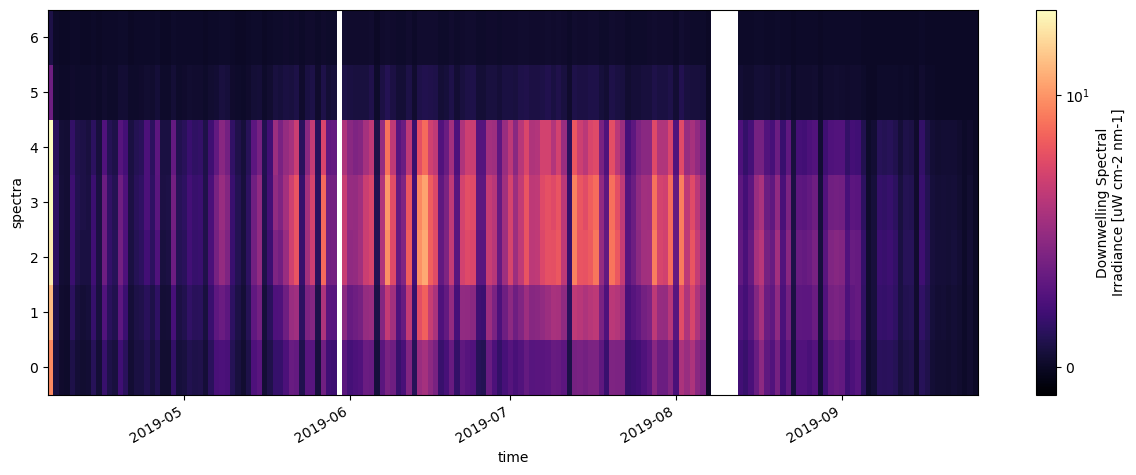

In [30]:
# pcolormesh plot with log-scale cmap except for [-1, 10] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [31]:
# Now lets try this with a 5-day median resample
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="5D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 35, spectra: 7)>
array([[6.82127204e-01, 9.39339140e-01, 1.49556243e+00, 1.66573864e+00,
        1.50775647e+00, 2.17019475e-01, 6.62599682e-02],
       [4.09351526e-01, 5.97971766e-01, 8.23282033e-01, 8.41685295e-01,
        7.24953008e-01, 1.07756459e-01, 4.46083474e-02],
       [1.11149060e+00, 1.63481436e+00, 2.06272259e+00, 1.99825457e+00,
        1.42778278e+00, 2.07900504e-01, 6.89136231e-02],
       [6.33905790e-01, 8.30168475e-01, 1.26737414e+00, 1.37036116e+00,
        1.22211412e+00, 1.81988724e-01, 5.88591173e-02],
       [4.88950510e-01, 7.05335209e-01, 1.08804481e+00, 1.18094031e+00,
        1.09429885e+00, 1.71634988e-01, 5.71144999e-02],
       [6.95715056e-01, 9.77443677e-01, 1.34453113e+00, 1.40168619e+00,
        1.25158622e+00, 1.94583331e-01, 6.10077514e-02],
       [1.77887788e+00, 2.40299210e+00, 3.25211386e+00, 3.32345650e+00,
        2.82799702e+00, 3.63398624e-01, 9.33474496e-02],
       [8.35149703e-01, 1.11870379e+00, 1.48298037e+00, 1.51192503e+00,
        1.28393037e+00, 1.92699171e-01, 5.95294177e-02],
       [1.19328147e+00, 1.70288643e+00, 2.52271664e+00, 2.78847411e+00,
        2.70395010e+00, 3.80136554e-01, 1.00454470e-01],
       [2.62830054e+00, 3.91435216e+00, 5.20132994e+00, 5.24724249e+00,
        4.42306642e+00, 5.73875815e-01, 1.45943075e-01],
...
       [2.06008457e+00, 2.58632186e+00, 3.16383481e+00, 2.98038643e+00,
        2.42941038e+00, 3.60160794e-01, 9.68550489e-02],
       [2.74753531e+00, 3.09858421e+00, 3.49182410e+00, 3.13586101e+00,
        2.39268108e+00, 3.07221372e-01, 8.25675502e-02],
       [2.20276612e+00, 2.58443371e+00, 2.88604360e+00, 2.58521177e+00,
        1.98243281e+00, 2.43159916e-01, 6.05670060e-02],
       [1.66826512e+00, 2.02154214e+00, 2.23259445e+00, 1.97611683e+00,
        1.40635816e+00, 1.69531314e-01, 4.33503864e-02],
       [2.70608963e+00, 3.34031155e+00, 3.58219552e+00, 3.11022829e+00,
        2.22732694e+00, 2.56595992e-01, 6.27982799e-02],
       [7.45937359e-01, 8.52196817e-01, 9.00792402e-01, 7.83724039e-01,
        6.10910023e-01, 8.67380087e-02, 2.31770994e-02],
       [1.05503826e+00, 1.35776975e+00, 1.46589740e+00, 1.28284831e+00,
        9.28877248e-01, 1.16683356e-01, 3.63260056e-02],
       [7.11412936e-01, 9.11214792e-01, 1.05646410e+00, 9.39103459e-01,
        7.16780233e-01, 8.74880143e-02, 2.91914385e-02],
       [3.15291575e-01, 3.98664721e-01, 4.91061523e-01, 4.47583359e-01,
        3.45641780e-01, 4.67864891e-02, 1.80901622e-02],
       [6.95465087e-03, 5.62515071e-03, 3.77377740e-03, 2.68314116e-03,
        3.17550394e-03, 3.19469816e-03, 4.37195968e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-11 ... 2019-09-23
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

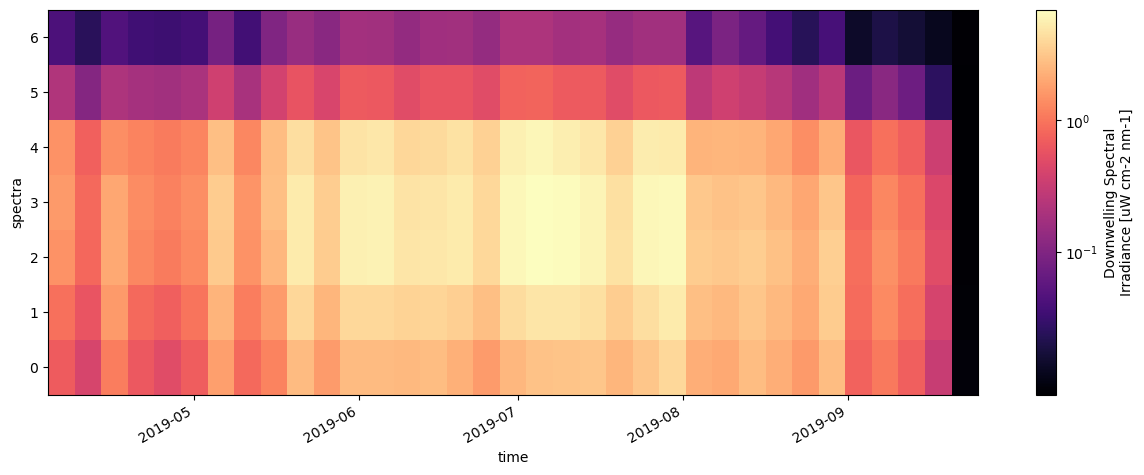

In [37]:
# 5-day median of downwelling spectral irradiance pcolormesh plot with log-scale cmap except for [0, 0.01] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=0.1))

### Surface Piercing Profilers

In [ ]:
# Scatter plot depth as a function of time and color points according to downwelling irradiance
fig, axs = plt.subplots(7,1)
m = 0
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        plt.scatter(spkir['time'], spkir['depth'], ax=axs[m], c=spkir[var])
        m += 1
# ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
# plt.legend()

In [23]:
ax[0]

<Axes: >

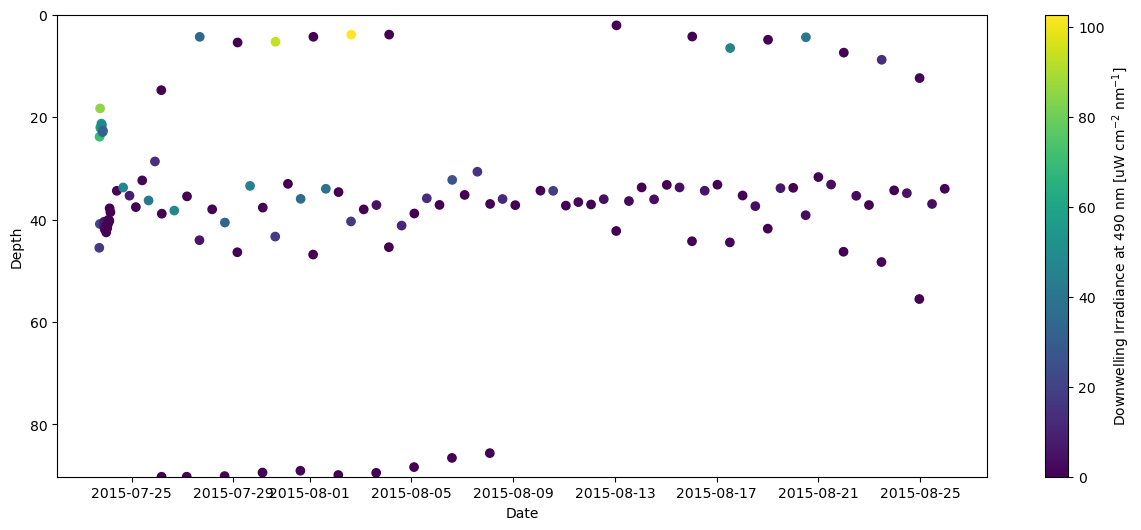

In [31]:
fig, ax = plt.subplots(figsize=(15,6))
sc = ax.scatter(spkir['time'], spkir['depth'], c=spkir['downwelling_irradiance_490'])
ax.set_ylim(spkir['depth'].max(), 0)
ax.set_xlabel('Date')
ax.set_ylabel('Depth')

cbar = fig.colorbar(sc)
cbar.set_label('Downwelling Irradiance at 490 nm [uW cm$^{-2}$ nm$^{-1}$]')